### In the orchestrator-workers workflow, a central LLM dynamically breaks down tasks, delegates them to worker LLMs, and synthesizers

In [1]:
from langchain_groq import ChatGroq
import os
from dotenv import load_dotenv

load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")

In [3]:
llm = ChatGroq(
    model= "llama-3.3-70b-versatile"
)

result = llm.invoke("Hello")
result

AIMessage(content='Hello. How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 36, 'total_tokens': 46, 'completion_time': 0.009678791, 'prompt_time': 0.010529731, 'queue_time': 0.049636369, 'total_time': 0.020208522}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3f3b593e33', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--949526c6-04d7-44de-898c-2eec5d45f9e1-0', usage_metadata={'input_tokens': 36, 'output_tokens': 10, 'total_tokens': 46})

In [28]:
from typing import Annotated, List
import operator
from typing_extensions import Literal
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, SystemMessage
from typing_extensions import TypedDict
from langgraph.graph import START, END, StateGraph
from IPython.display import Image, display, Markdown

In [11]:
class Section(BaseModel):
    name : str = Field(description="Name for this section of the report")
    description : str = Field(description="Brief Overview of the main topics and concepts of the section")
    
class Sections(BaseModel):
    sections : List[Section] = Field(
        description="Section of the report"
    )
    
planner = llm.with_structured_output(Sections)

### Creating Workers Dynamically in LangGraph

In [12]:
# Graph state
class State(TypedDict):
    topic : str
    sections : list[Section]
    completed_sections : Annotated[
        list,
        operator.add
    ]
    final_report : str
    
# Worker state
class WorkerState(TypedDict):
    section : Section
    completed_sections : Annotated[list, operator.add]

In [19]:
# Node
def orchestrator(state : State):
    report_sections = planner.invoke(
        [
            SystemMessage(content = "Generate a plan for the report"),
            HumanMessage(content = f"Here is the report topic : {state["topic"]}")
        ]
    )
    print("Report Sections : ", report_sections)
    
    return {"sections" : report_sections.sections}


def llm_call(state : WorkerState):
    
    section = llm.invoke(
        [
            SystemMessage(
                content = "Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name : {state["section"].name} and description: {state["section"].description}"
            )
        ]
    )
    return {"completed_sections" : [section.content]}
    

In [20]:
from langgraph.constants import Send

C:\Users\BOSS\AppData\Local\Temp\ipykernel_19884\4049780201.py:1: LangGraphDeprecatedSinceV10: Importing Send from langgraph.constants is deprecated. Please use 'from langgraph.types import Send' instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  from langgraph.constants import Send


In [21]:
# conditional edge
def assign_workers(state : State):
    return [Send("llm_call", {"section" : s}) for s in state["sections"]]


def synthesizer(state : State):
    completed_section = state["completed_sections"]
    
    completed_report_sections = "\n\n----\n\n".join(completed_section)
    
    return {"final_report" : completed_report_sections}

In [23]:
## Graph builder

orchestrator_worker_builder = StateGraph(State)

orchestrator_worker_builder.add_node("orchestrator",orchestrator)
orchestrator_worker_builder.add_node("llm_call",llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# edges
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator",
    assign_workers,
    ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)


orchestrator_worker = orchestrator_worker_builder.compile()



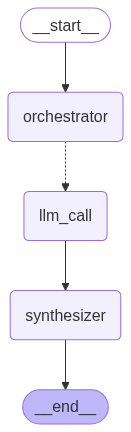

In [26]:
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

In [29]:
state = orchestrator_worker.invoke({"topic" : "Create a report on Agentic AI RAGs"})

Markdown(state["final_report"])

Report Sections :  sections=[Section(name='Introduction to Agentic AI RAGs', description='Overview of Agentic AI RAGs, their purpose, and significance'), Section(name='Technical Details of Agentic AI RAGs', description='In-depth explanation of the architecture, components, and functionality of Agentic AI RAGs'), Section(name='Applications and Use Cases of Agentic AI RAGs', description='Exploration of the various applications, use cases, and potential impact of Agentic AI RAGs'), Section(name='Challenges and Limitations of Agentic AI RAGs', description='Discussion of the challenges, limitations, and potential risks associated with Agentic AI RAGs'), Section(name='Conclusion and Future Directions for Agentic AI RAGs', description='Summary of key findings and future research directions for Agentic AI RAGs')]


### Introduction to Agentic AI RAGs
Agentic AI RAGs (Retrieve, Augment, Generate) are a type of artificial intelligence model designed to process and generate human-like text based on a given prompt or topic. The primary purpose of Agentic AI RAGs is to assist and augment human capabilities in tasks that require extensive research, writing, and critical thinking. 
#### Key Characteristics
* **Retrieve**: Agentic AI RAGs can retrieve relevant information from a vast database or the internet, allowing them to provide accurate and up-to-date information on a wide range of topics.
* **Augment**: These models can augment human capabilities by analyzing and processing large amounts of data, identifying patterns, and providing insights that may not be immediately apparent to humans.
* **Generate**: Agentic AI RAGs can generate high-quality text based on the retrieved and augmented information, making them useful for tasks such as content creation, research paper writing, and report generation.
#### Significance
The significance of Agentic AI RAGs lies in their potential to revolutionize the way we approach tasks that require extensive research, writing, and critical thinking. By leveraging the capabilities of Agentic AI RAGs, humans can focus on higher-level tasks that require creativity, empathy, and problem-solving skills, leading to increased productivity and efficiency. Additionally, Agentic AI RAGs can help bridge the knowledge gap by providing access to information and educational resources to people who may not have had access to them otherwise.

----

### Technical Details of Agentic AI RAGs
#### Architecture
Agentic AI RAGs (Retrieval-Augmented Generation) are built upon a modular architecture, comprising three primary components: 
* **Retriever**: responsible for retrieving relevant information from a vast knowledge base, 
* **Generator**: tasked with generating text based on the input prompt and the retrieved information, and 
* **Ranker**: evaluates the generated text and selects the most suitable output.

#### Components
The key components of Agentic AI RAGs include:
* **Knowledge Base**: a massive repository of text data that serves as the foundation for the retriever to fetch relevant information.
* **Embeddings**: used to represent the input prompt, the knowledge base, and the generated text in a high-dimensional vector space, facilitating efficient retrieval and comparison.
* **Neural Networks**: the core of the generator and ranker, comprising transformer-based architectures that enable complex pattern recognition and text generation.

#### Functionality
The functionality of Agentic AI RAGs can be broken down into the following stages:
1. **Prompt Analysis**: the input prompt is analyzed and embedded into a vector representation.
2. **Knowledge Retrieval**: the retriever fetches relevant information from the knowledge base based on the prompt embedding.
3. **Text Generation**: the generator creates text based on the input prompt and the retrieved information.
4. **Ranking and Selection**: the ranker evaluates the generated text and selects the most suitable output.
5. **Post-processing**: the final output is refined and polished through additional processing steps, such as spell-checking and fluency evaluation.

----

### Applications and Use Cases of Agentic AI RAGs
#### Introduction to Applications
Agentic AI RAGs (Retrieve, Augment, Generate) have a wide range of applications across various industries, leveraging their ability to process and generate human-like text based on the context provided. These applications can be broadly categorized into content creation, customer service, education, and research.

#### Content Creation
* **Content Generation**: Agentic AI RAGs can generate high-quality content, such as articles, blog posts, and social media updates, saving time and effort for content creators.
* **Creative Writing**: They can assist writers by suggesting plot twists, character developments, and even entire drafts, revolutionizing the creative writing process.
* **Translation and Localization**: By understanding the context and nuances of languages, Agentic AI RAGs can improve translation services, making content more accessible globally.

#### Customer Service
* **Chatbots and Virtual Assistants**: Integrating Agentic AI RAGs into chatbots and virtual assistants enhances their ability to understand and respond to customer inquiries more accurately and empathetically.
* **Personalized Recommendations**: They can analyze customer interactions and preferences to offer personalized product or service recommendations, enhancing the customer experience.
* **Feedback Analysis**: Agentic AI RAGs can analyze customer feedback, identifying patterns and areas for improvement, which can inform business strategies.

#### Education
* **Intelligent Tutoring Systems**: These AI models can create customized learning materials and adaptive assessments, providing students with a more personalized learning experience.
* **Automated Grading**: They can assist teachers by grading assignments and exams, freeing up time for more critical aspects of education.
* **Language Learning Tools**: Agentic AI RAGs can generate interactive language lessons, conversations, and exercises, making language learning more engaging and effective.

#### Research
* **Literature Review Automation**: They can quickly scan through vast amounts of research papers, identifying relevant studies, and summarizing key findings.
* **Hypothesis Generation**: By analyzing existing research, Agentic AI RAGs can suggest new hypotheses for further investigation, potentially leading to groundbreaking discoveries.
* **Data Analysis**: They can analyze complex datasets, identifying patterns and correlations that might elude human researchers, and generate reports based on their findings.

#### Potential Impact
The integration of Agentic AI RAGs across these applications and use cases has the potential to significantly impact various aspects of society and industry. They can enhance efficiency, personalize experiences, and uncover new insights. However, it's crucial to address challenges related to data privacy, bias, and the ethical use of AI to ensure that these technologies benefit humanity as a whole.

----

### Challenges and Limitations of Agentic AI RAGs
#### Introduction to Challenges
Agentic AI RAGs (Retrieval-Augmented Generation) face numerous challenges and limitations that hinder their widespread adoption and effectiveness. These challenges can be broadly categorized into technical, ethical, and societal limitations.

#### Technical Challenges
* **Data Quality and Availability**: Agentic AI RAGs require large amounts of high-quality training data to generate accurate and informative responses. However, collecting and curating such data can be time-consuming and expensive.
* **Model Complexity**: The complexity of Agentic AI RAGs can make them difficult to train and fine-tune, requiring significant computational resources and expertise.
* **Explainability and Transparency**: The black-box nature of Agentic AI RAGs can make it challenging to understand how they arrive at their responses, limiting their trustworthiness and reliability.

#### Ethical Challenges
* **Bias and Fairness**: Agentic AI RAGs can perpetuate and amplify existing biases present in the training data, leading to unfair and discriminatory outcomes.
* **Privacy and Security**: The use of Agentic AI RAGs raises concerns about data privacy and security, particularly when dealing with sensitive or personal information.
* **Accountability and Responsibility**: The autonomous nature of Agentic AI RAGs can make it difficult to assign accountability and responsibility for their actions and decisions.

#### Societal Challenges
* **Job Displacement and Automation**: The increasing use of Agentic AI RAGs can lead to job displacement and automation, particularly in industries where tasks are repetitive or can be easily automated.
* **Dependence on Technology**: Over-reliance on Agentic AI RAGs can lead to a decline in human skills and abilities, making us vulnerable to technological failures or cyber attacks.
* **Social Isolation and Polarization**: The use of Agentic AI RAGs can exacerbate social isolation and polarization by creating echo chambers and reinforcing existing beliefs and biases.

#### Mitigating Challenges and Limitations
To address these challenges and limitations, it is essential to develop and implement strategies that prioritize transparency, explainability, and accountability in Agentic AI RAGs. This can be achieved through:
* **Multidisciplinary Research**: Encouraging collaboration between technologists, social scientists, and ethicists to develop more comprehensive and nuanced understanding of Agentic AI RAGs.
* **Regulatory Frameworks**: Establishing regulatory frameworks that ensure the safe and responsible development and deployment of Agentic AI RAGs.
* **Public Awareness and Education**: Raising public awareness and education about the benefits and risks associated with Agentic AI RAGs, promoting a more informed and critical discourse about their use and impact.

----

### Conclusion and Future Directions for Agentic AI RAGs
#### Summary of Key Findings
The development of Agentic AI RAGs (Retrieval-Augmented Generators) has shown promising results in improving the performance and efficiency of AI models. Key findings include:
* Enhanced contextual understanding and response generation capabilities
* Improved handling of complex and open-ended tasks
* Increased ability to learn from experience and adapt to new situations
* Potential for more effective human-AI collaboration and decision-making

#### Future Research Directions
To further advance the field of Agentic AI RAGs, future research directions may include:
* **Multimodal Interaction**: Exploring the integration of Agentic AI RAGs with multimodal interfaces to enable more natural and intuitive human-AI interaction
* **Explainability and Transparency**: Developing methods to provide insights into the decision-making processes of Agentic AI RAGs and ensure transparency in their actions
* **Scalability and Robustness**: Investigating techniques to improve the scalability and robustness of Agentic AI RAGs in complex and dynamic environments
* **Ethical Considerations**: Examining the ethical implications of Agentic AI RAGs and developing guidelines for their responsible development and deployment
* **Real-World Applications**: Applying Agentic AI RAGs to real-world problems and domains, such as healthcare, education, and finance, to demonstrate their practical value and potential impact.